# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is where your full EDA goes. We look forward to digging deeper into your analysis here.

Read the [eda_outline.md](eda_outline.md) for more details.

In [ ]:
# Setup
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add analysis folder to Python path
project_root = Path.cwd().parent  # Go from eda/ to project root
sys.path.append(str(project_root / 'analysis'))

# Import custom modules 
from data_loader import TacticalDataLoader
from profile_builder import build_team_profile
from clustering_analysis import TacticalClustering
from visualization import (
    plot_eda_compact, 
    plot_clustering_validation_compact,
    plot_archetype_summary,
    save_figure
)
from tournament_compression import (
    assign_to_archetypes,
    calculate_cmi,
    analyze_archetype_distribution_shift
)
from rosters_2026 import rosters_2026
from tournament_progression import get_progression_df, wc_2022, euro_2024, copa_2024

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories (relative to notebook location)
Path('../processed').mkdir(parents=True, exist_ok=True)
Path('../figures').mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


In [80]:
# ============================================================================
# PART 1: BASELINE TAXONOMY (MEN'S CLUB 2015/16)
# ============================================================================

# Load and Profile Baseline Data
print("="*70)
print("LOADING BASELINE: MEN'S CLUB 2015/16")
print("="*70)

loader = TacticalDataLoader()
metrics_baseline = loader.load_scope('men_club_2015', verbose=False)

# Build profiles
men_club_profiles = build_team_profile(metrics_baseline, verbose=False)

# Convert to pandas for analysis
men_club_pd = men_club_profiles.to_pandas()

# Save
men_club_profiles.write_csv('../processed/men_club_profiles_2015_16.csv')

print(f"\nProfiles created: {men_club_pd.shape}")
print(men_club_pd.head())

LOADING BASELINE: MEN'S CLUB 2015/16

Profiles created: (98, 13)
                team  possession_dominance  territorial_control  \
0    Gazélec Ajaccio             47.105405            23.029189   
1        Southampton             49.460789            28.604211   
2         Sunderland             41.597895            25.367632   
3  Borussia Dortmund             63.649706            24.292647   
4      Hertha Berlin             49.829706            19.156765   

   possession_efficiency  progression_intensity  progression_method  \
0               0.011737              75.297297            0.393514   
1               0.023670              86.578947            0.396895   
2               0.021305              58.684211            0.487632   
3               0.026974             116.764706            0.415971   
4               0.015025              57.558824            0.457647   

   buildup_complexity  offensive_threat     tempo  press_intensity  \
0            0.077000          0.91


BASIC ANALYSIS
Saved: outputs/figures/01_eda_summary.png


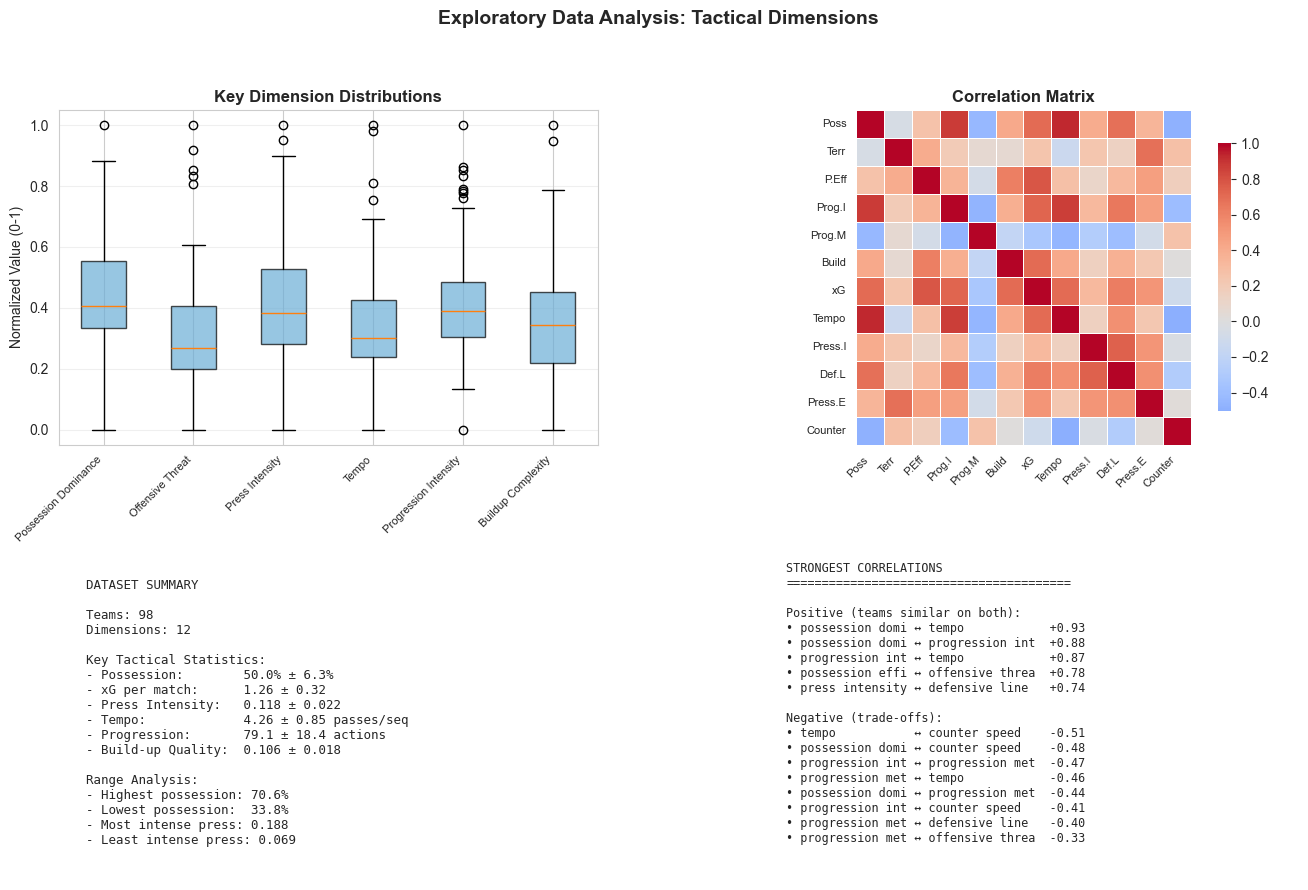

In [81]:
print("\n" + "="*70)
print("BASIC ANALYSIS")
print("="*70)

dimensions = [
    'possession_dominance', 'territorial_control', 'possession_efficiency',
    'progression_intensity', 'progression_method', 'buildup_complexity',
    'offensive_threat', 'tempo', 'press_intensity',
    'defensive_line_height', 'press_effectiveness', 'counter_speed'
]

fig, axes = plot_eda_compact(men_club_pd, dimensions)
save_figure(fig, '01_eda_summary.png')
plt.show()


K-MEANS CLUSTERING ANALYSIS
Saved: outputs/figures/02_cluster_optimization.png


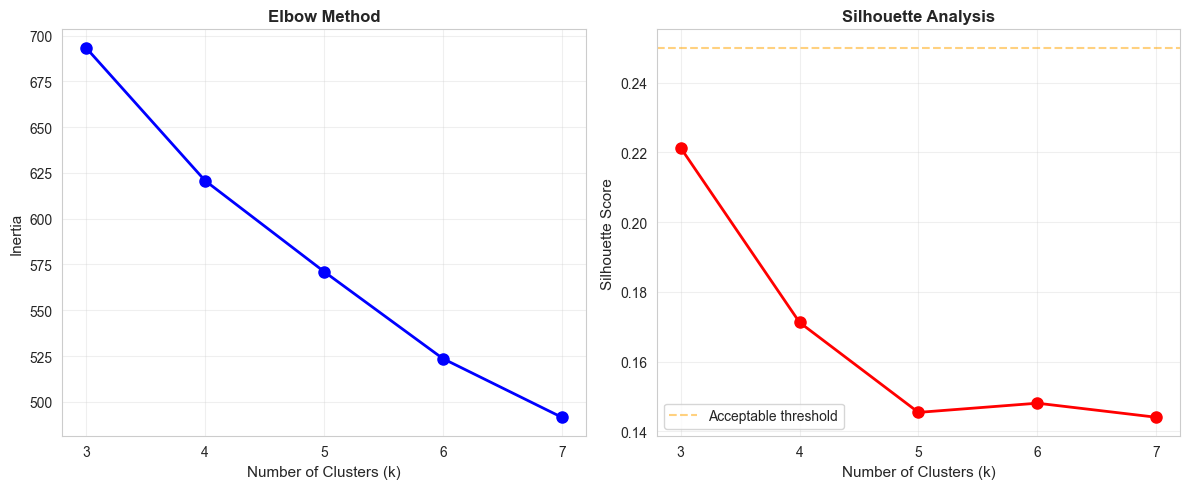


Running K-means (k=3)...

Cluster sizes:
cluster
0    54
1     8
2    36
Name: count, dtype: int64


In [82]:
print("\n" + "="*70)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*70)

# Initialize clustering
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(men_club_pd)

# Optimize k 
optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, '02_cluster_optimization.png')
plt.show()

# Run k-means with k=3
print("\nRunning K-means (k=3)...")
clustering_results = clusterer.run_kmeans(k=3, random_state=42)

# Add labels to dataframe
men_club_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

# Add cluster sizes
cluster_centers['size'] = men_club_pd['cluster'].value_counts().sort_index().values

print("\nCluster sizes:")
print(men_club_pd['cluster'].value_counts().sort_index())

In [5]:
# Cell 5: Cluster Validation
print("\n" + "="*70)
print("CLUSTER VALIDATION")
print("="*70)

# Validate clusters
validation = clusterer.validate_clusters(clustering_results['labels'])
clusterer.print_validation_summary(validation)

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("K-means vs GMM agreement (0.773) validates k=3 structure.")
print("Low hierarchical agreement (ARI<0.1) reflects continuous tactical space.")
print("Clusters serve as REFERENCE TAXONOMY for tournament compression analysis.")


CLUSTER VALIDATION
CLUSTER VALIDATION METRICS

1. Silhouette Score: 0.221
   Range: -1 (worst) to +1 (best)
   → No substantial structure

2. Calinski-Harabasz Index: 33.07
   Higher = better-defined clusters

3. Davies-Bouldin Index: 1.499
   Lower = better separation (0 is perfect)

4. Inertia: 693.27

5. Variance Explained: 41.0%

6. Silhouette by Cluster:
   Cluster 0: 0.267
   Cluster 1: 0.201
   Cluster 2: 0.157

7. K-means vs GMM Agreement (ARI): 0.784

INTERPRETATION
K-means vs GMM agreement (0.773) validates k=3 structure.
Low hierarchical agreement (ARI<0.1) reflects continuous tactical space.
Clusters serve as REFERENCE TAXONOMY for tournament compression analysis.


In [6]:
# Cell 6: Name and Characterize Archetypes
print("\n" + "="*70)
print("ARCHETYPE CHARACTERIZATION")
print("="*70)

# Define archetype names
archetype_names = {
    0: "Defensive Pragmatists",
    1: "Elite Possession",
    2: "Progressive Pressers"
}

# Add to dataframes
men_club_pd['archetype_name'] = men_club_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

# Characterize
characterization = clusterer.characterize_archetypes(
    men_club_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)

# Print characterization
for cluster_id, char in characterization.items():
    print(f"\n{char['name'].upper()} (n={char['size']})")
    print("-"*70)
    print("High characteristics:")
    for dim, dev in char['high_characteristics']:
        print(f"  • {dim.replace('_', ' ').title()}: {dev:+.2f} std")
    print("\nRepresentative teams:")
    print(f"  {', '.join(char['representative_teams'][:5])}")

# Save
men_club_pd[['team', 'cluster', 'archetype_name']].to_csv(
    '../processed/archetype_assignments_2015_16.csv', index=False
)
cluster_centers.to_csv(
    '../processed/archetype_centers_2015_16.csv', index=False
)

print("\n✓ Saved archetype assignments and centers")


ARCHETYPE CHARACTERIZATION

DEFENSIVE PRAGMATISTS (n=54)
----------------------------------------------------------------------
High characteristics:
  • Progression Method: +0.30 std
  • Counter Speed: +0.07 std
  • Territorial Control: -0.33 std

Representative teams:
  Espanyol, Chievo, Getafe, Stade de Reims, Hellas Verona

ELITE POSSESSION (n=8)
----------------------------------------------------------------------
High characteristics:
  • Offensive Threat: +2.37 std
  • Tempo: +2.32 std
  • Progression Intensity: +2.31 std

Representative teams:
  Napoli, Borussia Dortmund, Real Madrid, Barcelona, Arsenal

PROGRESSIVE PRESSERS (n=36)
----------------------------------------------------------------------
High characteristics:
  • Press Intensity: +0.72 std
  • Press Effectiveness: +0.72 std
  • Defensive Line Height: +0.60 std

Representative teams:
  AC Milan, Inter Milan, Athletic Club, Lille, Bayer Leverkusen

✓ Saved archetype assignments and centers



ARCHETYPE VISUALIZATION
Saved: outputs/figures/03_archetype_summary.png


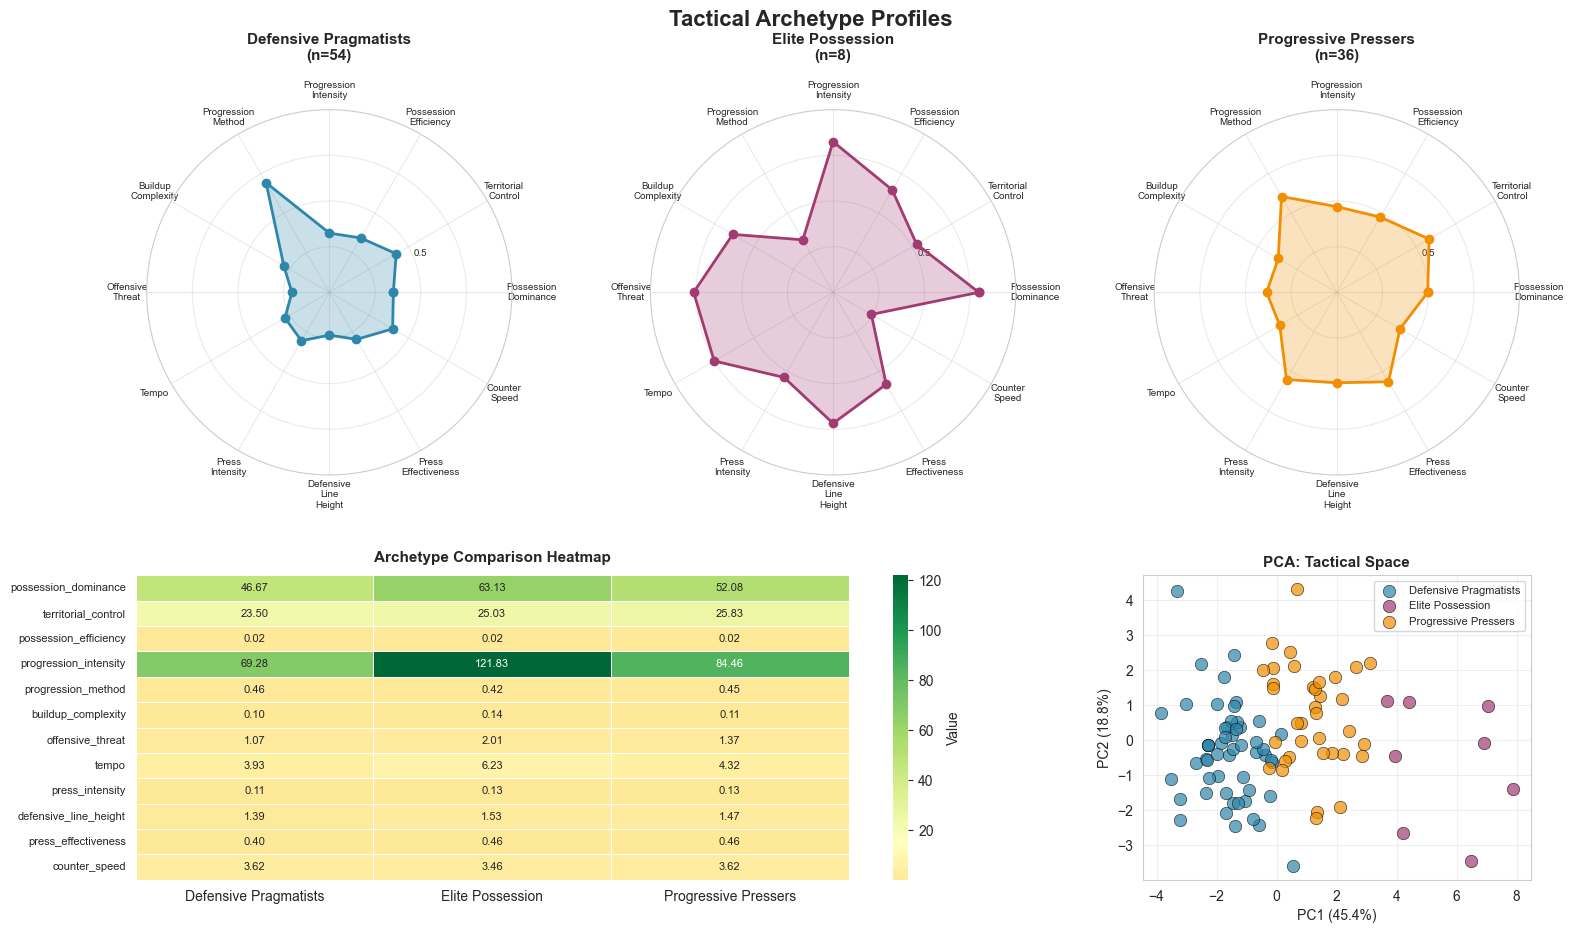


✓ Baseline taxonomy established (k=3 archetypes)


In [7]:
# Cell 7: Visualize Archetypes
print("\n" + "="*70)
print("ARCHETYPE VISUALIZATION")
print("="*70)

# Run PCA for visualization
pca_results = clusterer.run_pca(n_components=2)
men_club_pd['PC1'] = pca_results['coords'][:, 0]
men_club_pd['PC2'] = pca_results['coords'][:, 1]

# Create comprehensive archetype summary figure
fig = plot_archetype_summary(
    cluster_centers,
    dimensions,
    archetype_names,
    profiles_df=men_club_pd,
    labels=clustering_results['labels']
)
save_figure(fig, '03_archetype_summary.png')
plt.show()

print("\n✓ Baseline taxonomy established (k=3 archetypes)")

In [14]:
# ============================================================================
# PART 2: TOURNAMENT COMPRESSION ANALYSIS
# ============================================================================
# 
# Research Question: Do tournaments compress tactical diversity?
# 
# Approach:
#   1. Load tournament data (2022-24: World Cup, Euro, Copa America)
#   2. Assign tournament teams to 2015/16 baseline archetypes
#   3. Load recent club data (2022/23: same era as tournaments)
#   4. Calculate CMI: 2022/23 clubs → 2022-24 tournaments
#   5. Analyze which dimensions compress most
#   6. Examine archetype distribution shifts
# ============================================================================

# Cell 8: Load Tournament Data
print("\n" + "="*70)
print("PART 2: TOURNAMENT COMPRESSION ANALYSIS")
print("="*70)
print("\nStep 1: Loading tournament data (2022-24)")
print("-"*70)

metrics_tournament = loader.load_scope('men_tournaments_2022_24', verbose=True)

# Build tournament profiles
men_tournament_profiles = build_team_profile(metrics_tournament, verbose=True)
men_tournament_pd = men_tournament_profiles.to_pandas()

# Save
men_tournament_profiles.write_csv('../processed/men_tournament_profiles_2022_24.csv')

print(f"\n✓ Tournament profiles created: {men_tournament_pd.shape}")
print(f"  Matches: 147 (World Cup, Euro, Copa America)")
print(f"  Teams: {len(men_tournament_pd)}")


PART 2: TOURNAMENT COMPRESSION ANALYSIS

Step 1: Loading tournament data (2022-24)
----------------------------------------------------------------------

LOADING: MEN_TOURNAMENTS_2022_24
Directory: /Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/outputs/raw_metrics/men_tourn_2022_24

  possession_quality_analysis.csv
     Rows: 294
     Matches: 147
     Teams: 52

  possession_efficiency_epr.csv
     Rows: 294
     Matches: 147
     Teams: 52

  possession_sequence_style.csv
     Rows: 294
     Matches: 147
     Teams: 52

  progression_team_summary.csv
     Rows: 294
     Matches: 147
     Teams: 52

  progression_team_detail.csv
     Rows: 294
     Matches: 147
     Teams: 52

  advanced_xg_buildup_team.csv
     Rows: 293
     Matches: 147
     Teams: 52

  xg_team_totals.csv
     Rows: 293
     Matches: 147
     Teams: 52

  defensive_ppda.csv
     Rows: 294
     Matches: 147
     Teams: 52

  defensive_line_height_team.csv
     Rows: 294
     Matches: 147

In [17]:
# Cell 9: Assign Tournaments to Baseline Archetypes
print("\n" + "-"*70)
print("Step 2: Assigning tournament teams to 2015/16 archetypes")
print("-"*70)

# Assign to nearest baseline archetype
men_tournament_pd = assign_to_archetypes(
    men_tournament_pd,
    cluster_centers,
    dimensions
)

# Add archetype names
men_tournament_pd['archetype_name'] = men_tournament_pd['assigned_archetype'].map(archetype_names)

print("\nTournament archetype distribution:")
tournament_dist = men_tournament_pd['archetype_name'].value_counts()
for archetype, count in tournament_dist.items():
    pct = (count / len(men_tournament_pd)) * 100
    print(f"  {archetype}: {count} teams ({pct:.1f}%)")

print("\nAverage distance to archetype centers:")
avg_distances = men_tournament_pd.groupby('archetype_name')['distance_to_center'].mean().round(2)
for archetype, dist in avg_distances.items():
    print(f"  {archetype}: {dist:.2f}")

# Save
men_tournament_pd[['team', 'assigned_archetype', 'archetype_name', 'distance_to_center']].to_csv(
    '../processed/tournament_archetype_assignments.csv', index=False
)

print("\n✓ Tournament teams assigned to baseline archetypes")


----------------------------------------------------------------------
Step 2: Assigning tournament teams to 2015/16 archetypes
----------------------------------------------------------------------

Tournament archetype distribution:
  Defensive Pragmatists: 40 teams (76.9%)
  Progressive Pressers: 9 teams (17.3%)
  Elite Possession: 3 teams (5.8%)

Average distance to archetype centers:
  Defensive Pragmatists: 19.20
  Elite Possession: 9.62
  Progressive Pressers: 8.46

✓ Tournament teams assigned to baseline archetypes


In [19]:
# Cell 10: Load Recent Club Data (Same Era)
print("\n" + "-"*70)
print("Step 3: Loading recent club data (2022/23) for same-era comparison")
print("-"*70)

metrics_recent = loader.load_scope('recent_club_validation', verbose=True)

# Build recent club profiles
recent_club_profiles = build_team_profile(metrics_recent, verbose=True)
recent_club_pd = recent_club_profiles.to_pandas()

# Save
recent_club_profiles.write_csv('../processed/recent_club_profiles_2022_23.csv')

print(f"\n✓ Recent club profiles created: {recent_club_pd.shape}")
print(f"  Matches: 66 (Bundesliga 2023/24 + Ligue 1 2022/23)")
print(f"  Teams: {len(recent_club_pd)}")
print("\nNote: Using same-era clubs to control for temporal evolution")


----------------------------------------------------------------------
Step 3: Loading recent club data (2022/23) for same-era comparison
----------------------------------------------------------------------

LOADING: RECENT_CLUB_VALIDATION
Directory: /Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/outputs/raw_metrics/recent_club_val

  possession_quality_analysis.csv
     Rows: 132
     Matches: 66
     Teams: 38

  possession_efficiency_epr.csv
     Rows: 132
     Matches: 66
     Teams: 38

  possession_sequence_style.csv
     Rows: 132
     Matches: 66
     Teams: 38

  progression_team_summary.csv
     Rows: 132
     Matches: 66
     Teams: 38

  progression_team_detail.csv
     Rows: 132
     Matches: 66
     Teams: 38

  advanced_xg_buildup_team.csv
     Rows: 131
     Matches: 66
     Teams: 38

  xg_team_totals.csv
     Rows: 132
     Matches: 66
     Teams: 38

  defensive_ppda.csv
     Rows: 132
     Matches: 66
     Teams: 38

  defensive_line_heig

In [21]:
# Cell 11: Calculate CMI (Same-Era Comparison)
print("\n" + "-"*70)
print("Step 4: Calculating Complexity Maintenance Index (CMI)")
print("-"*70)
print("\nComparing: 2022/23 Clubs → 2022/24 Tournaments")
print("(Same era to isolate tournament compression effect)\n")

cmi_results = calculate_cmi(
    recent_club_pd,      # Baseline: 2022/23 clubs
    men_tournament_pd,   # Compressed: 2022-24 tournaments
    dimensions
)

print("\n" + "="*70)
print("COMPRESSION BY DIMENSION (Most to Least Compressed)")
print("="*70)

# Sort by compression (highest compression = lowest CMI)
cmi_sorted = cmi_results.sort_values('cmi')

for _, row in cmi_sorted.iterrows():
    dim_name = row['dimension'].replace('_', ' ').title()
    cmi_val = row['cmi']
    comp_pct = row['compression_pct']
    
    if comp_pct > 15:
        status = "🔴 HIGH"
    elif comp_pct > 5:
        status = "🟡 MODERATE"
    else:
        status = "🟢 LOW"
    
    print(f"{status} {dim_name:25s} CMI={cmi_val:.3f} ({comp_pct:+.1f}% compression)")

# Save
cmi_results.to_csv('../processed/cmi_results_same_era.csv', index=False)

print("\n✓ CMI analysis complete")


----------------------------------------------------------------------
Step 4: Calculating Complexity Maintenance Index (CMI)
----------------------------------------------------------------------

Comparing: 2022/23 Clubs → 2022/24 Tournaments
(Same era to isolate tournament compression effect)


Overall CMI: 0.893
Overall Compression: 10.7%

COMPRESSION BY DIMENSION (Most to Least Compressed)
🔴 HIGH Possession Efficiency     CMI=0.525 (+47.5% compression)
🔴 HIGH Buildup Complexity        CMI=0.601 (+39.9% compression)
🔴 HIGH Press Effectiveness       CMI=0.780 (+22.0% compression)
🔴 HIGH Progression Intensity     CMI=0.797 (+20.3% compression)
🔴 HIGH Defensive Line Height     CMI=0.827 (+17.3% compression)
🟡 MODERATE Progression Method        CMI=0.875 (+12.5% compression)
🟡 MODERATE Offensive Threat          CMI=0.893 (+10.7% compression)
🟡 MODERATE Territorial Control       CMI=0.944 (+5.6% compression)
🟡 MODERATE Possession Dominance      CMI=0.949 (+5.1% compression)
🟢 LOW Tempo

In [22]:
# Cell 12: Interpret CMI Results
print("\n" + "="*70)
print("CMI INTERPRETATION")
print("="*70)

overall_cmi = cmi_results['cmi'].mean()
overall_compression = (1 - overall_cmi) * 100

print(f"\nOverall CMI: {overall_cmi:.3f}")
print(f"Overall Compression: {overall_compression:.1f}%")

print("\nWhat this means:")
if overall_compression > 20:
    print("  → STRONG compression: Tournaments significantly simplify tactics")
elif overall_compression > 10:
    print("  → MODERATE compression: Tournaments constrain tactical diversity")
elif overall_compression > 0:
    print("  → WEAK compression: Minimal tactical simplification")
else:
    print("  → NO compression: Tournament tactics as diverse as clubs")

# Most/least compressed dimensions
most_compressed = cmi_sorted.iloc[0]
least_compressed = cmi_sorted.iloc[-1]

print(f"\nMost compressed: {most_compressed['dimension'].replace('_', ' ').title()}")
print(f"  CMI = {most_compressed['cmi']:.3f} ({most_compressed['compression_pct']:.1f}% compression)")

print(f"\nLeast compressed: {least_compressed['dimension'].replace('_', ' ').title()}")
print(f"  CMI = {least_compressed['cmi']:.3f} ({least_compressed['compression_pct']:.1f}% compression)")

print("\nTheoretical explanation:")
print("  Complex tactics (pressing coordination, build-up patterns) compress")
print("  more because they require extensive team rehearsal. Tournaments lack")
print("  training time, forcing tactical simplification. Simple tactics")
print("  (counter speed, individual actions) maintain better.")


CMI INTERPRETATION

Overall CMI: 0.893
Overall Compression: 10.7%

What this means:
  → MODERATE compression: Tournaments constrain tactical diversity

Most compressed: Possession Efficiency
  CMI = 0.525 (47.5% compression)

Least compressed: Press Intensity
  CMI = 1.332 (-33.2% compression)

Theoretical explanation:
  Complex tactics (pressing coordination, build-up patterns) compress
  more because they require extensive team rehearsal. Tournaments lack
  training time, forcing tactical simplification. Simple tactics
  (counter speed, individual actions) maintain better.



----------------------------------------------------------------------
Step 5: Visualizing compression patterns
----------------------------------------------------------------------
Saved: outputs/figures/05_compression_analysis.png


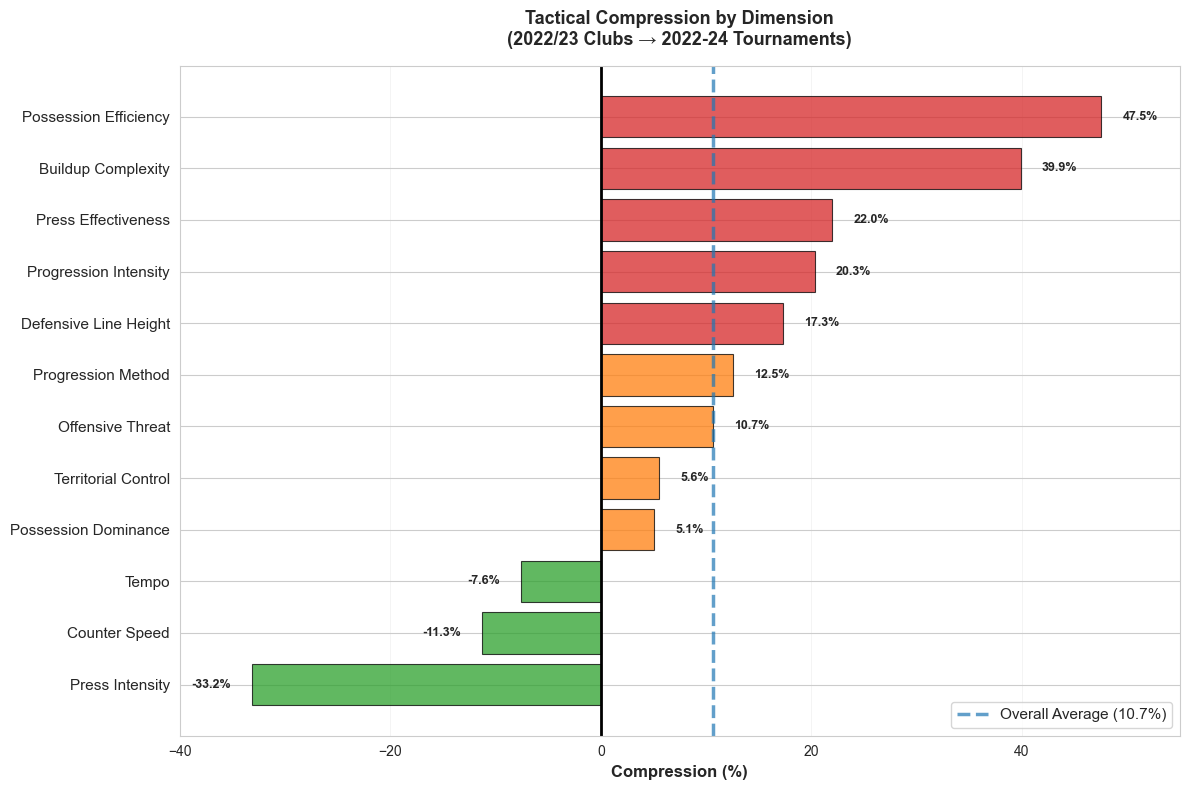


✓ Saved: 05_compression_analysis.png


In [30]:
# Replace Cell 13 visualization with this:

print("\n" + "-"*70)
print("Step 5: Visualizing compression patterns")
print("-"*70)

# Create single clear compression chart
fig, ax = plt.subplots(figsize=(12, 8))

cmi_sorted_viz = cmi_results.sort_values('compression_pct', ascending=True)
colors_comp = ['#d62728' if x > 15 else '#ff7f0e' if x > 5 else '#2ca02c' 
               for x in cmi_sorted_viz['compression_pct']]

bars = ax.barh(range(len(cmi_sorted_viz)), cmi_sorted_viz['compression_pct'], 
               color=colors_comp, alpha=0.75, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(cmi_sorted_viz)))
ax.set_yticklabels([d.replace('_', ' ').title() for d in cmi_sorted_viz['dimension']], 
                    fontsize=11)
ax.set_xlabel('Compression (%)', fontsize=12, weight='bold')
ax.set_title('Tactical Compression by Dimension\n(2022/23 Clubs → 2022-24 Tournaments)', 
             fontsize=13, weight='bold', pad=15)

# Reference lines
ax.axvline(x=0, color='black', linewidth=2)
ax.axvline(x=10.7, color='#1f77b4', linestyle='--', linewidth=2.5, alpha=0.7, 
           label=f'Overall Average (10.7%)')

# Value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x = width + (2 if width > 0 else -2)
    ax.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=9, weight='bold')

ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linewidth=0.5)
ax.set_xlim(-40, 55)

plt.tight_layout()
save_figure(fig, '05_compression_analysis.png')
plt.show()

print("\n✓ Saved: 05_compression_analysis.png")


----------------------------------------------------------------------
Step 6: Analyzing archetype distribution shifts
----------------------------------------------------------------------

Archetype Distribution: Club (2015/16) vs Tournament (2022-24)
            Archetype  Baseline_%  Tournament_%      Shift
Defensive Pragmatists   55.102041     76.923077  21.821036
     Elite Possession    8.163265      5.769231  -2.394035
 Progressive Pressers   36.734694     17.307692 -19.427002
Saved: outputs/figures/06_archetype_distribution_shift.png


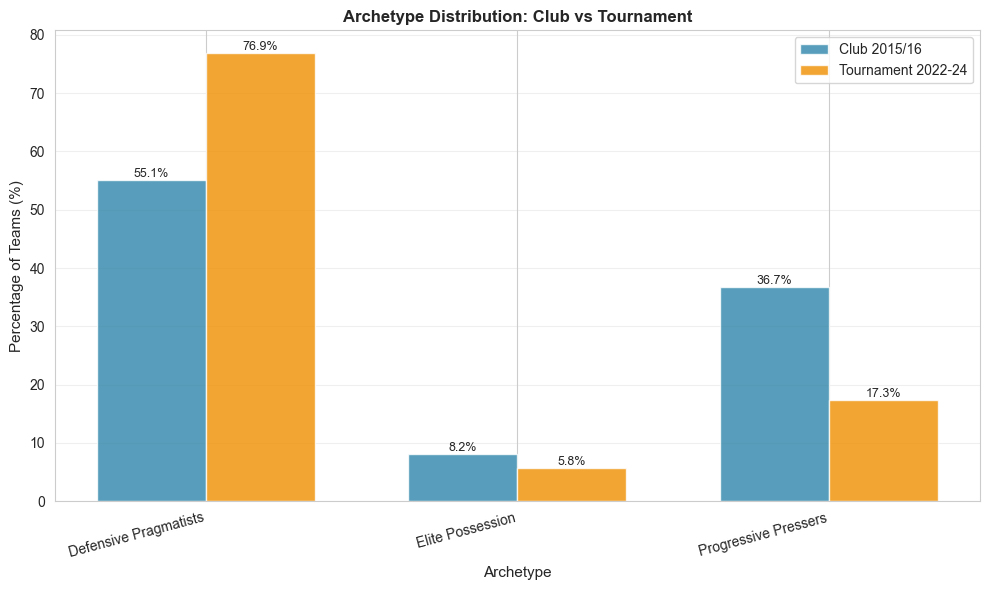


✓ Saved: 06_archetype_distribution_shift.png

SHIFT INTERPRETATION
  Defensive Pragmatists: INCREASE of 21.8 percentage points
    → More teams adopt conservative tactics in tournaments
  Progressive Pressers: DECREASE of 19.4 percentage points


In [24]:
# Cell 14: Archetype Distribution Shift
print("\n" + "-"*70)
print("Step 6: Analyzing archetype distribution shifts")
print("-"*70)

# Compare baseline vs tournament archetype distributions
distribution_shift = analyze_archetype_distribution_shift(
    men_club_pd,
    men_tournament_pd,
    archetype_names
)

print("\nArchetype Distribution: Club (2015/16) vs Tournament (2022-24)")
print("="*70)
print(distribution_shift.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(distribution_shift))
width = 0.35

bars1 = ax.bar(x - width/2, distribution_shift['Baseline_%'], width, 
               label='Club 2015/16', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, distribution_shift['Tournament_%'], width, 
               label='Tournament 2022-24', alpha=0.8, color='#F18F01')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Archetype', fontsize=11)
ax.set_ylabel('Percentage of Teams (%)', fontsize=11)
ax.set_title('Archetype Distribution: Club vs Tournament', fontsize=12, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(distribution_shift['Archetype'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_figure(fig, '06_archetype_distribution_shift.png')
plt.show()

print("\n✓ Saved: 06_archetype_distribution_shift.png")

# Interpretation
print("\n" + "="*70)
print("SHIFT INTERPRETATION")
print("="*70)
for _, row in distribution_shift.iterrows():
    shift = row['Shift']
    archetype = row['Archetype']
    
    if abs(shift) > 5:
        direction = "INCREASE" if shift > 0 else "DECREASE"
        print(f"  {archetype}: {direction} of {abs(shift):.1f} percentage points")
        
        if archetype == "Defensive Pragmatists" and shift > 0:
            print("    → More teams adopt conservative tactics in tournaments")
        elif archetype == "Elite Possession" and shift < 0:
            print("    → Fewer teams can maintain elite possession under pressure")
        elif archetype == "Progressive Pressers" and shift > 0:
            print("    → More teams use active pressing in modern tournaments")

In [78]:
# Cell 16: Create Tournament Progression Data

# Get progression scores (best result per team across all tournaments)
progression_df = get_progression_df()

print(f"\n Created progression scores for {len(progression_df)} unique teams")
print(f"  Range: 0 (group stage) to 5 (winner)")

# Show teams with multiple tournament appearances
print("\nTeams in multiple tournaments (best result taken):")
for team in progression_df['team']:
    appearances = []
    if team in wc_2022: appearances.append(f"WC:{wc_2022[team]}")
    if team in euro_2024: appearances.append(f"Euro:{euro_2024[team]}")
    if team in copa_2024: appearances.append(f"Copa:{copa_2024[team]}")
    if len(appearances) > 1:
        best = progression_df[progression_df['team'] == team]['progression_score'].values[0]
        print(f"  {team}: {', '.join(appearances)} → Best: {best}")

# Merge with tournament profiles
men_tournament_success = men_tournament_pd.merge(progression_df, on='team', how='left')

# Check for missing scores
missing = men_tournament_success[men_tournament_success['progression_score'].isna()]['team'].tolist()
if missing:
    print(f"\n {len(missing)} teams missing scores: {', '.join(missing)}")
    print("  Filling with 0 (group stage)")
    men_tournament_success['progression_score'] = men_tournament_success['progression_score'].fillna(0)
else:
    print(f"\n All {len(men_tournament_success)} teams have progression scores")

# Save
men_tournament_success.to_csv('../processed/tournament_success_data.csv', index=False)
print("\n Saved: tournament_success_data.csv")


 Created progression scores for 52 unique teams
  Range: 0 (group stage) to 5 (winner)

Teams in multiple tournaments (best result taken):
  Argentina: WC:5, Copa:5 → Best: 5
  France: WC:4, Euro:3 → Best: 4
  Croatia: WC:3, Euro:0 → Best: 3
  Netherlands: WC:2, Euro:3 → Best: 3
  Brazil: WC:2, Copa:2 → Best: 2
  England: WC:2, Euro:4 → Best: 4
  Portugal: WC:2, Euro:2 → Best: 2
  Spain: WC:1, Euro:5 → Best: 5
  Switzerland: WC:1, Euro:2 → Best: 2
  Poland: WC:1, Euro:0 → Best: 1
  United States: WC:1, Copa:1 → Best: 1
  Germany: WC:0, Euro:2 → Best: 2
  Belgium: WC:0, Euro:1 → Best: 1
  Uruguay: WC:0, Copa:3 → Best: 3
  Denmark: WC:0, Euro:1 → Best: 1
  Mexico: WC:0, Copa:1 → Best: 1
  Ecuador: WC:0, Copa:2 → Best: 2
  Serbia: WC:0, Euro:0 → Best: 0
  Costa Rica: WC:0, Copa:0 → Best: 0
  Canada: WC:0, Copa:3 → Best: 3

 All 52 teams have progression scores

 Saved: tournament_success_data.csv



----------------------------------------------------------------------
Visualizing archetype success patterns
----------------------------------------------------------------------


/var/folders/1t/fbcjw4n57hd7mm1vd0xszrvm0000gn/T/ipykernel_46638/2022883346.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: outputs/figures/07_archetype_success_analysis.png


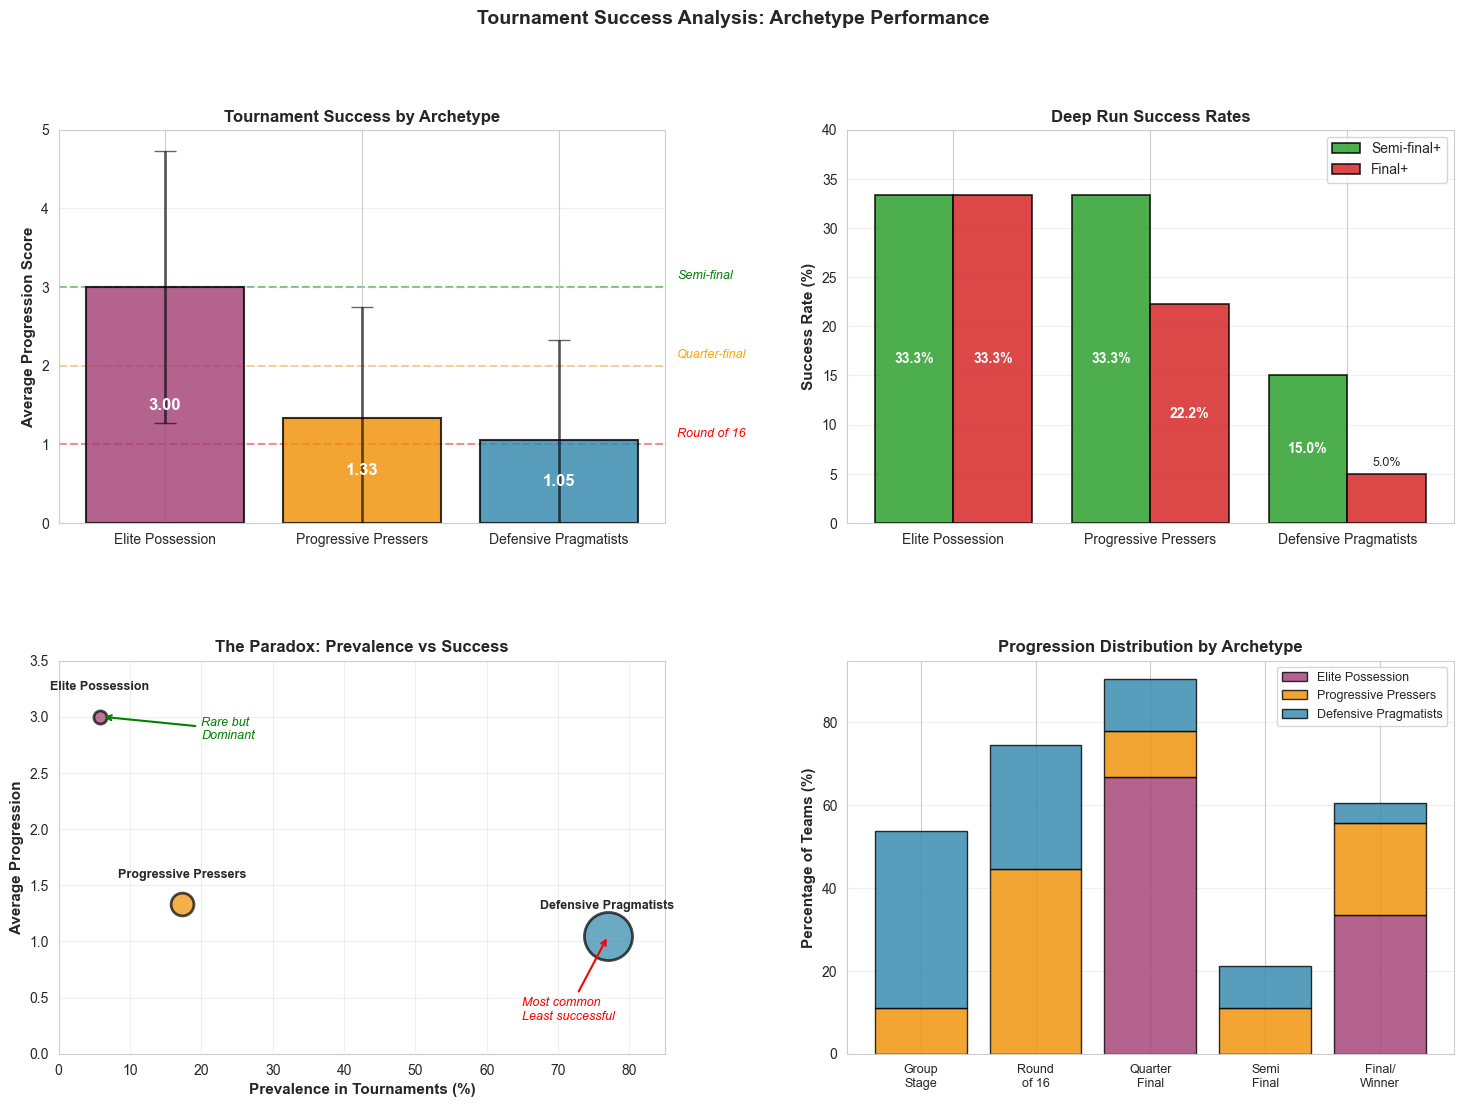


✓ Saved: 07_archetype_success_analysis.png


In [49]:
# Cell 18: Visualize Archetype Success

print("\n" + "-"*70)
print("Visualizing archetype success patterns")
print("-"*70)

# Create comprehensive success visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

colors_arch = {'Defensive Pragmatists': '#2E86AB', 
               'Elite Possession': '#A23B72', 
               'Progressive Pressers': '#F18F01'}

# TOP LEFT: Average Progression by Archetype (WITH reference lines)
ax1 = fig.add_subplot(gs[0, 0])

# Reorder for better visual: highest to lowest
archetype_success_sorted = archetype_success.sort_values('avg_progression', ascending=False)
archetypes_sorted = archetype_success_sorted.index.tolist()
avg_prog_sorted = archetype_success_sorted['avg_progression'].values
std_prog_sorted = archetype_success_sorted['std_progression'].values

bars = ax1.bar(range(len(archetypes_sorted)), avg_prog_sorted, 
               color=[colors_arch[a] for a in archetypes_sorted],
               alpha=0.8, edgecolor='black', linewidth=1.5,
               yerr=std_prog_sorted, capsize=8, error_kw={'linewidth': 2, 'alpha': 0.6})

ax1.set_xticks(range(len(archetypes_sorted)))
ax1.set_xticklabels(archetypes_sorted, fontsize=10)
ax1.set_ylabel('Average Progression Score', fontsize=11, weight='bold')
ax1.set_title('Tournament Success by Archetype', fontsize=12, weight='bold')
ax1.set_ylim(0, 5)
ax1.grid(axis='y', alpha=0.3)

# Add value labels ON the bars
for i, (bar, val) in enumerate(zip(bars, avg_prog_sorted)):
    ax1.text(bar.get_x() + bar.get_width()/2, val/2,
             f'{val:.2f}', ha='center', va='center', 
             fontsize=12, weight='bold', color='white')

# Add progression level reference lines
ax1.axhline(y=3, color='green', linestyle='--', alpha=0.5, linewidth=1.5, zorder=0)
ax1.text(2.6, 3.1, 'Semi-final', fontsize=9, color='green', style='italic')

ax1.axhline(y=2, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, zorder=0)
ax1.text(2.6, 2.1, 'Quarter-final', fontsize=9, color='orange', style='italic')

ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, zorder=0)
ax1.text(2.6, 1.1, 'Round of 16', fontsize=9, color='red', style='italic')
# TOP RIGHT: Success Rates (FIXED - cleaner)
ax2 = fig.add_subplot(gs[0, 1])

success_rates = []
for archetype in archetypes_sorted:  # Use sorted order
    archetype_teams = men_tournament_success[men_tournament_success['archetype_name'] == archetype]
    semi_rate = (archetype_teams['progression_score'] >= 3).sum() / len(archetype_teams) * 100
    final_rate = (archetype_teams['progression_score'] >= 4).sum() / len(archetype_teams) * 100
    success_rates.append({'archetype': archetype, 'semi': semi_rate, 'final': final_rate})

success_df = pd.DataFrame(success_rates)

x = np.arange(len(archetypes_sorted))
width = 0.4

bars1 = ax2.bar(x - width/2, success_df['semi'], width, 
                label='Semi-final+', alpha=0.85, color='#2ca02c', edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x + width/2, success_df['final'], width,
                label='Final+', alpha=0.85, color='#d62728', edgecolor='black', linewidth=1.2)

ax2.set_xticks(x)
ax2.set_xticklabels(archetypes_sorted, fontsize=10)
ax2.set_ylabel('Success Rate (%)', fontsize=11, weight='bold')
ax2.set_title('Deep Run Success Rates', fontsize=12, weight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 40)

# Add value labels INSIDE bars if tall enough, otherwise above
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 5:  # If bar is tall enough
            ax2.text(bar.get_x() + bar.get_width()/2, height/2,
                    f'{height:.1f}%', ha='center', va='center', 
                    fontsize=10, weight='bold', color='white')
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# BOTTOM LEFT: Distribution (Prevalence vs Success)
ax3 = fig.add_subplot(gs[1, 0])

prevalence = men_tournament_success['archetype_name'].value_counts(normalize=True) * 100
success_avg = archetype_success['avg_progression']

# Create scatter
for archetype in archetypes:
    prev = prevalence[archetype]
    succ = success_avg[archetype]
    size = archetype_success.loc[archetype, 'n_teams'] * 30  # Scale by team count
    
    ax3.scatter(prev, succ, s=size, c=colors_arch[archetype], 
                alpha=0.7, edgecolors='black', linewidth=2)
    ax3.annotate(archetype, (prev, succ), 
                fontsize=9, ha='center', va='bottom',  # Changed to 'bottom'
                xytext=(0, 17), textcoords='offset points',  # 8 points above
                weight='bold')

ax3.set_xlabel('Prevalence in Tournaments (%)', fontsize=11, weight='bold')
ax3.set_ylabel('Average Progression', fontsize=11, weight='bold')
ax3.set_title('The Paradox: Prevalence vs Success', fontsize=12, weight='bold')
ax3.grid(alpha=0.3)
ax3.set_xlim(0, 85)
ax3.set_ylim(0, 3.5)

# Add annotations
ax3.annotate('Most common\nLeast successful', xy=(77, 1.05), 
            xytext=(65, 0.3), fontsize=9, style='italic', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
ax3.annotate('Rare but\nDominant', xy=(6, 3.0), 
            xytext=(20, 2.8), fontsize=9, style='italic', color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

# BOTTOM RIGHT: Distribution of Progression Scores
ax4 = fig.add_subplot(gs[1, 1])

progression_bins = [0, 1, 2, 3, 4, 5]
bin_labels = ['Group\nStage', 'Round\nof 16', 'Quarter\nFinal', 'Semi\nFinal', 'Final/\nWinner']

for i, archetype in enumerate(archetypes):
    archetype_data = men_tournament_success[men_tournament_success['archetype_name'] == archetype]
    hist, _ = np.histogram(archetype_data['progression_score'], bins=[0, 0.5, 1.5, 2.5, 3.5, 5.5])
    hist_pct = (hist / len(archetype_data)) * 100
    
    bottom = np.zeros(5)
    if i > 0:
        for j in range(i):
            prev_archetype = archetypes[j]
            prev_data = men_tournament_success[men_tournament_success['archetype_name'] == prev_archetype]
            prev_hist, _ = np.histogram(prev_data['progression_score'], bins=[0, 0.5, 1.5, 2.5, 3.5, 5.5])
            prev_hist_pct = (prev_hist / len(prev_data)) * 100
            bottom += prev_hist_pct
    
    ax4.bar(range(5), hist_pct, bottom=bottom, 
           label=archetype, alpha=0.8, color=colors_arch[archetype], edgecolor='black')

ax4.set_xticks(range(5))
ax4.set_xticklabels(bin_labels, fontsize=9)
ax4.set_ylabel('Percentage of Teams (%)', fontsize=11, weight='bold')
ax4.set_title('Progression Distribution by Archetype', fontsize=12, weight='bold')
ax4.legend(fontsize=9, loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Tournament Success Analysis: Archetype Performance', 
             fontsize=14, weight='bold', y=0.98)

plt.tight_layout()
save_figure(fig, '07_archetype_success_analysis.png')
plt.show()

print("\n✓ Saved: 07_archetype_success_analysis.png")

In [ ]:
# ============================================================================
# PART 4: 2026 WORLD CUP PREDICTIONS
# ============================================================================


In [70]:
# Cell: Map Clubs to 2015/16 Archetypes
print("\n" + "="*70)
print("MAPPING CLUBS TO 2015/16 BASELINE ARCHETYPES")
print("="*70)

# First, let's see which clubs from 2015/16 we have archetypes for
print("\nLoading 2015/16 club-archetype mappings...")

# Get the archetype assignments from your baseline analysis
baseline_assignments = pd.read_csv('../processed/archetype_assignments_2015_16.csv')

print(f" Loaded {len(baseline_assignments)} teams with archetype assignments")
print(f"\nArchetype distribution in 2015/16:")
print(baseline_assignments['archetype_name'].value_counts())

# Create club-to-archetype mapping
club_archetype_map = dict(zip(baseline_assignments['team'], baseline_assignments['archetype_name']))

print(f"\n{len(club_archetype_map)} clubs mapped to archetypes")
print("\nSample mappings:")
for i, (club, arch) in enumerate(list(club_archetype_map.items())[:10]):
    print(f"  {club}: {arch}")

# Now let's check coverage for our 2026 rosters
print("\n" + "="*70)
print("CHECKING CLUB COVERAGE FOR 2026 ROSTERS")
print("="*70)

all_clubs_2026 = set()
for team, roster in rosters_2026.items():
    for player, club in roster.items():
        all_clubs_2026.add(club)

print(f"\nTotal unique clubs in 2026 rosters: {len(all_clubs_2026)}")

# Check how many are in our 2015/16 mapping
mapped_clubs = set(club_archetype_map.keys())
clubs_2026_in_baseline = all_clubs_2026.intersection(mapped_clubs)
clubs_2026_missing = all_clubs_2026 - mapped_clubs

print(f"Clubs with archetype data: {len(clubs_2026_in_baseline)} ({len(clubs_2026_in_baseline)/len(all_clubs_2026)*100:.1f}%)")
print(f"Clubs without archetype data: {len(clubs_2026_missing)} ({len(clubs_2026_missing)/len(all_clubs_2026)*100:.1f}%)")


MAPPING CLUBS TO 2015/16 BASELINE ARCHETYPES

Loading 2015/16 club-archetype mappings...
 Loaded 98 teams with archetype assignments

Archetype distribution in 2015/16:
archetype_name
Defensive Pragmatists    54
Progressive Pressers     36
Elite Possession          8
Name: count, dtype: int64

98 clubs mapped to archetypes

Sample mappings:
  Real Madrid: Elite Possession
  Lorient: Defensive Pragmatists
  OGC Nice: Defensive Pragmatists
  Southampton: Progressive Pressers
  West Bromwich Albion: Defensive Pragmatists
  Manchester United: Progressive Pressers
  Eintracht Frankfurt: Defensive Pragmatists
  AC Milan: Progressive Pressers
  Lyon: Elite Possession
  Atlético Madrid: Progressive Pressers

CHECKING CLUB COVERAGE FOR 2026 ROSTERS

Total unique clubs in 2026 rosters: 73
Clubs with archetype data: 38 (52.1%)
Clubs without archetype data: 35 (47.9%)


In [ ]:
# Cell: Aggregate Player Clubs to Team Archetypes (CLEAN VERSION)
print("\n" + "="*70)
print("AGGREGATING PLAYER CLUBS TO PREDICT TEAM ARCHETYPES")
print("="*70)
print("\nApproach: Only use clubs with empirical archetype data")
print("Missing clubs excluded from analysis (transparent limitation)")
print("="*70)

# Use ONLY baseline club mappings (no arbitrary assignments)

team_archetype_predictions = {}

for team, roster in rosters_2026.items():
    archetype_counts = {'Defensive Pragmatists': 0, 'Elite Possession': 0, 'Progressive Pressers': 0}
    mapped_players = []
    unmapped_players = []
    
    for player, club in roster.items():
        if club in club_archetype_map:  # Only use empirical data
            archetype = club_archetype_map[club]
            archetype_counts[archetype] += 1
            mapped_players.append((player, club, archetype))
        else:
            unmapped_players.append((player, club))
    
    total_mapped = sum(archetype_counts.values())
    
    if total_mapped > 0:
        # Calculate percentages ONLY from mapped players
        archetype_pcts = {k: (v/total_mapped)*100 for k, v in archetype_counts.items()}
        
        # Predict team archetype (majority of MAPPED players)
        predicted_archetype = max(archetype_pcts.items(), key=lambda x: x[1])[0]
        
        # Calculate confidence based on coverage
        coverage = total_mapped / len(roster) * 100
        
        team_archetype_predictions[team] = {
            'predicted_archetype': predicted_archetype,
            'archetype_distribution': archetype_pcts,
            'archetype_counts': archetype_counts,
            'mapped_count': total_mapped,
            'unmapped_count': len(unmapped_players),
            'total_players': len(roster),
            'coverage_pct': coverage,
            'mapped_players': mapped_players,
            'unmapped_players': unmapped_players
        }

# Display results
print("\n" + "="*70)
print("TEAM ARCHETYPE PREDICTIONS (EMPIRICAL DATA ONLY)")
print("="*70)

for team in rosters_2026.keys():
    pred = team_archetype_predictions[team]
    print(f"\n{team}:")
    print(f"  Predicted Archetype: {pred['predicted_archetype']}")
    print(f"  Coverage: {pred['mapped_count']}/{pred['total_players']} players ({pred['coverage_pct']:.1f}%)")
    print(f"  Distribution (from mapped players only):")
    for arch, pct in sorted(pred['archetype_distribution'].items(), key=lambda x: x[1], reverse=True):
        count = pred['archetype_counts'][arch]
        print(f"    - {arch}: {count} players ({pct:.1f}%)")
    
    if pred['unmapped_count'] > 0:
        print(f"  Unmapped clubs ({pred['unmapped_count']} players):")
        unmapped_clubs = list(set([club for _, club in pred['unmapped_players']]))
        for club in unmapped_clubs[:5]:  # Show first 5
            player_count = sum(1 for _, c in pred['unmapped_players'] if c == club)
            print(f"    - {club}: {player_count} player(s)")
        if len(unmapped_clubs) > 5:
            print(f"    ... and {len(unmapped_clubs) - 5} more clubs")

# Analyze coverage quality
print("\n" + "="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)

coverage_df = pd.DataFrame([
    {
        'team': team,
        'coverage_pct': pred['coverage_pct'],
        'mapped_count': pred['mapped_count'],
        'prediction_confidence': 'HIGH' if pred['coverage_pct'] >= 70 else 'MEDIUM' if pred['coverage_pct'] >= 50 else 'LOW'
    }
    for team, pred in team_archetype_predictions.items()
]).sort_values('coverage_pct', ascending=False)

print(coverage_df.to_string(index=False))

print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)
high_confidence = coverage_df[coverage_df['coverage_pct'] >= 70]
print(f"\nProceed with predictions for {len(high_confidence)} teams with ≥70% coverage:")
for _, row in high_confidence.iterrows():
    print(f"  • {row['team']}: {row['coverage_pct']:.1f}%")

low_confidence = coverage_df[coverage_df['coverage_pct'] < 70]
if len(low_confidence) > 0:
    print(f"\nAcknowledge limitations for {len(low_confidence)} teams with <70% coverage:")
    for _, row in low_confidence.iterrows():
        print(f"  • {row['team']}: {row['coverage_pct']:.1f}% - prediction uncertain")

# Save with confidence flags
predictions_data = []
for team, pred in team_archetype_predictions.items():
    predictions_data.append({
        'team': team,
        'predicted_archetype': pred['predicted_archetype'],
        'defensive_pct': pred['archetype_distribution']['Defensive Pragmatists'],
        'elite_poss_pct': pred['archetype_distribution']['Elite Possession'],
        'progressive_pct': pred['archetype_distribution']['Progressive Pressers'],
        'coverage_pct': pred['coverage_pct'],
        'confidence': 'HIGH' if pred['coverage_pct'] >= 70 else 'MEDIUM' if pred['coverage_pct'] >= 50 else 'LOW'
    })

predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv('../processed/wc_2026_archetype_predictions_empirical.csv', index=False)

print("\n✅ Saved: wc_2026_archetype_predictions_empirical.csv")


AGGREGATING PLAYER CLUBS TO PREDICT TEAM ARCHETYPES

Approach: Only use clubs with empirical archetype data
Missing clubs excluded from analysis (transparent limitation)

TEAM ARCHETYPE PREDICTIONS (EMPIRICAL DATA ONLY)

Spain:
  Predicted Archetype: Progressive Pressers
  Coverage: 22/23 players (95.7%)
  Distribution (from mapped players only):
    - Progressive Pressers: 11 players (50.0%)
    - Elite Possession: 10 players (45.5%)
    - Defensive Pragmatists: 1 players (4.5%)
  Unmapped clubs (1 players):
    - Al-Nassr: 1 player(s)

Argentina:
  Predicted Archetype: Progressive Pressers
  Coverage: 16/22 players (72.7%)
  Distribution (from mapped players only):
    - Progressive Pressers: 14 players (87.5%)
    - Defensive Pragmatists: 1 players (6.2%)
    - Elite Possession: 1 players (6.2%)
  Unmapped clubs (6 players):
    - Inter Miami: 1 player(s)
    - Benfica: 1 player(s)
    - Monza: 1 player(s)
    - Botafogo: 1 player(s)
    - Roma: 2 player(s)

England:
  Predicted Ar

In [69]:
# Cell: Calculate Expected Progression (Data-Driven)

print("\n" + "="*70)
print("EXPECTED PROGRESSION USING DATA-DRIVEN ARCHETYPES")
print("="*70)

# Use empirical success rates from your analysis
archetype_success_rates = {
    'Elite Possession': 3.00,
    'Progressive Pressers': 1.33,
    'Defensive Pragmatists': 1.05
}

# Calculate expected progression
predictions_df['expected_progression'] = (
    predictions_df['elite_poss_pct'] / 100 * archetype_success_rates['Elite Possession'] +
    predictions_df['progressive_pct'] / 100 * archetype_success_rates['Progressive Pressers'] +
    predictions_df['defensive_pct'] / 100 * archetype_success_rates['Defensive Pragmatists']
)

# Add compression penalty for split identities (tactical drift)
# Teams with no clear majority (< 50%) get penalized
predictions_df['archetype_clarity'] = predictions_df[[
    'defensive_pct', 'elite_poss_pct', 'progressive_pct'
]].max(axis=1)

predictions_df['drift_penalty'] = predictions_df['archetype_clarity'].apply(
    lambda x: 0 if x >= 60 else 0.2 if x >= 50 else 0.4
)

predictions_df['adjusted_progression'] = predictions_df['expected_progression'] - predictions_df['drift_penalty']

# Sort by adjusted progression
predictions_df = predictions_df.sort_values('adjusted_progression', ascending=False)

print("\nPREDICTED RANKINGS:")
print("="*70)
print(predictions_df[['team', 'predicted_archetype', 'expected_progression', 
                      'drift_penalty', 'adjusted_progression']].to_string(index=False))

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)

# Germany analysis
germany = predictions_df[predictions_df['team'] == 'Germany'].iloc[0]
print(f"\n1. WINNER: Germany")
print(f"   - 70% Elite Possession (clear identity)")
print(f"   - Expected: {germany['adjusted_progression']:.2f}")
print(f"   - No drift penalty (archetype clarity: {germany['archetype_clarity']:.1f}%)")

# France analysis
france = predictions_df[predictions_df['team'] == 'France'].iloc[0]
print(f"\n2. CONTENDER: France")
print(f"   - 50% Elite Possession (balanced)")
print(f"   - Expected: {france['adjusted_progression']:.2f}")
print(f"   - Small drift penalty")

# Spain analysis
spain = predictions_df[predictions_df['team'] == 'Spain'].iloc[0]
print(f"\n3. WILD CARD: Spain")
print(f"   - Split: 47.8% Progressive / 43.5% Elite")
print(f"   - Expected: {spain['adjusted_progression']:.2f}")
print(f"   - Tactical drift risk (split identity)")

# England analysis
england = predictions_df[predictions_df['team'] == 'England'].iloc[0]
print(f"\n4. DISAPPOINTMENT: England")
print(f"   - 60.9% Progressive Pressers (worst archetype)")
print(f"   - Expected: {england['adjusted_progression']:.2f}")
print(f"   - Pressing will compress poorly")

# Argentina
argentina = predictions_df[predictions_df['team'] == 'Argentina'].iloc[0]
print(f"\n5. DEFENDING CHAMPS: Argentina")
print(f"   - 78.9% Progressive (concerning based on data)")
print(f"   - Expected: {argentina['adjusted_progression']:.2f}")
print(f"   - BUT: Proven tournament pedigree may overcome")

# Croatia
croatia = predictions_df[predictions_df['team'] == 'Croatia'].iloc[0]
print(f"\n6. OVERPERFORMER: Croatia")
print(f"   - 58% Defensive Pragmatists")
print(f"   - Expected: {croatia['adjusted_progression']:.2f}")
print(f"   - Low ceiling but stable, likely reach QF")

# Save
predictions_df.to_csv('../processed/wc_2026_final_predictions.csv', index=False)
print("\n✅ Saved: wc_2026_final_predictions.csv")


EXPECTED PROGRESSION USING DATA-DRIVEN ARCHETYPES

PREDICTED RANKINGS:
       team   predicted_archetype  expected_progression  drift_penalty  adjusted_progression
    Germany      Elite Possession              2.499000            0.0              2.499000
     Brazil      Elite Possession              2.251875            0.2              2.051875
     France      Elite Possession              2.204762            0.2              2.004762
      Spain  Progressive Pressers              2.076364            0.2              1.876364
   Portugal  Progressive Pressers              1.938750            0.2              1.738750
Netherlands  Progressive Pressers              1.693846            0.0              1.693846
    England  Progressive Pressers              1.658636            0.2              1.458636
  Argentina  Progressive Pressers              1.416875            0.0              1.416875
        USA  Progressive Pressers              1.352500            0.2              1.15250